### View the data


In [1]:
import pandas as pd

news = pd.read_csv('C:/Users/Admin/Desktop/DataSmart/Modul3/AI+ML/Project/Fakenews/news.csv')

# Überprüfen auf fehlende Daten
missing_data = news.isnull().sum()

# Anzeigen der ersten Zeilen des Datensatzes, fehlenden Daten und Shape
news.head(), print(missing_data), news.shape

Unnamed: 0    0
title         0
text          0
label         0
dtype: int64


(   Unnamed: 0                                              title  \
 0        8476                       You Can Smell Hillary’s Fear   
 1       10294  Watch The Exact Moment Paul Ryan Committed Pol...   
 2        3608        Kerry to go to Paris in gesture of sympathy   
 3       10142  Bernie supporters on Twitter erupt in anger ag...   
 4         875   The Battle of New York: Why This Primary Matters   
 
                                                 text label  
 0  Daniel Greenfield, a Shillman Journalism Fello...  FAKE  
 1  Google Pinterest Digg Linkedin Reddit Stumbleu...  FAKE  
 2  U.S. Secretary of State John F. Kerry said Mon...  REAL  
 3  — Kaydee King (@KaydeeKing) November 9, 2016 T...  FAKE  
 4  It's primary day in New York and front-runners...  REAL  ,
 None,
 (6335, 4))

### Explore the data

Anzahl 'FAKE': 3164
Anzahl 'REAL': 3171


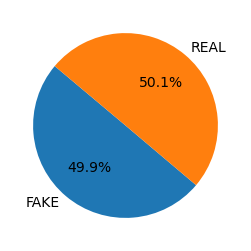

In [2]:
import matplotlib.pyplot as plt

# Verhältnis von FAKE zu REAL zählen
fake_count = news[news['label'] == 'FAKE'].shape[0]
real_count = news[news['label'] == 'REAL'].shape[0]
print("Anzahl 'FAKE':", fake_count)
print("Anzahl 'REAL':", real_count)

# Tortendiagramm erstellen
plt.figure(figsize=(4, 3))
plt.pie([fake_count, real_count], labels=['FAKE', 'REAL'], autopct='%1.1f%%', startangle=140)
plt.show()

#### Cleaning data  
###### --> entfällt, da keine leeren Zellen vorhanden sind

#### Define Data - NLTK (Natural Language Toolkit)

In [3]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

# Konfiguration für NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english')) # Erkennt Stop-Wörter wie Artikel, Pronomen etc für die Sprache Englisch
porter = PorterStemmer() # Initialisierung des PorterStemmer
lemmatizer = WordNetLemmatizer() # Lemmatisierung, d.h. Wörter werden auf Grundformen reduziert (z.B. besser -> gut)

# Textvorbereitung
def preprocess_text(text):
    text = text.lower() # Kleinbuchstaben umwandeln
    tokens = word_tokenize(text)  # Tokenisierung
    tokens_without_stopwords = [token for token in tokens if token not in stop_words]  # Entfernen von Stopwörtern
    stemmed_tokens = [porter.stem(token) for token in tokens_without_stopwords if token.isalpha()]    # Anwenden von Stemming
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens_without_stopwords if token.isalpha()]    # Anwenden von Lemmatisierung
    processed_text = ' '.join(lemmatized_tokens)   # Zusammenführen der Tokens zu einem Text
    return processed_text

# Anwenden der Tokens auf die gesamte Spalte "Text"
news['processed_text'] = news['text'].apply(preprocess_text)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### Define Data - TF-IDF (Term Frequency-Inverse Document Frequency)

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Merkmale extrahieren
tfidf_vectorizer = TfidfVectorizer(max_features=2000)
    # Wandelt Text in Zahlen um,
    # Wichtigkeit eines Wortes relativ zu seiner Häufigkeit im Dokument
    # hierbei werden nur die 1000 häufigsten Wörter als Merkmale definiert
X = tfidf_vectorizer.fit_transform(news['processed_text']) # setzt die neuen Text-Zahlen als X
y = news['label'] # setzt die FAKE/REAL klassifikation als Y
feature_names = tfidf_vectorizer.get_feature_names_out() 

#### Feature-Übersicht

In [5]:
# Anzeigen der Top-Features
print("Top-20 Wortmerkmale:")
print(feature_names[:20])

Top-20 Wortmerkmale:
['abedin' 'ability' 'able' 'abortion' 'absolutely' 'abuse' 'accept'
 'access' 'according' 'account' 'accusation' 'accused' 'acknowledged'
 'across' 'act' 'acting' 'action' 'active' 'activist' 'activity']


### Parameter-Optimierung  

In [6]:
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# Initialisierung der Modelle (selbsterklärend)
models = {
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(),
    "Support Vector Machine": SVC(),
    "Logistische Regression": LogisticRegression(),
    "Gradient Boosting Machine": GradientBoostingClassifier(),
    "K-nearest neighbor": KNeighborsClassifier()
}

# Hyperparameter für jedes Modell festlegen (Parameterraster)
param_grids = {
    "Naive Bayes": {'alpha': [0.1, 1, 10]},
        # Alpha gibt die Glättung im Modell an
    "Random Forest": {'n_estimators': [50, 100, 200], 'max_depth': [10, 20]},
        # Estimators sind Baumanzahl, während depth die Tiefe der Bäume angibt
        # Zunächst war als Estimator auch "300" angegeben --> zugunsten der Rechendauer entfernt
        # Zunächst war als Tiefe auch "None" angegeben, d.h. so tief wie maximal nötgig --> zugunsten der Rechendauer entfernt
    "Support Vector Machine": {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']},
        # C ist ein 'Regularisierungsparameter' und bestimmt die größe der Marge (Abstand der Trennlinien); größere C tendieren zum Overfitting, kleinere C tendieren zu Klassifizierungsfehlern
        # kernel gibt den Typ an, hier linear und radial basis function (rbf) -> also linear und non-linear
    "Logistische Regression": {'C': [0.1, 1, 10], 'max_iter':[250, 500]},
        # C ist hier äquivalent wie bei der SVM
        # Standard sind maximal 100 iterationen, jedoch führte das zu Fehlermeldungen. Daher wurde das Maximum erhöht auf 1000
    "Gradient Boosting Machine": {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 1]},
        # Estimators sind Baumanzahl wie bei Random Forest, learnindrate ist die Lernrate aka Kovergenzgeschwindigkeit
    "K-nearest neighbor": {'n_neighbors': [3, 5, 7]}
        # Anzahl der zu berücksichtigenden Nachbarn
}

# Festlegen des pos_labels als string anstatt =1
scoring = {'accuracy': 'accuracy',
           'precision': make_scorer(precision_score, pos_label='REAL'),
           'recall': make_scorer(recall_score, pos_label='REAL'),
           'f1': make_scorer(f1_score, pos_label='REAL')}
     # -> normalerweise erfolgt GS & KV mit "pos_label=1" und führt damit sonst zu Warnhinweisen

#### Train/Test Split  
<sub> Durch Testung wurde erkenntlich, dass eine Ratio von 90:10 gegenüber 80:20 meist etwa 3-5% höhere Accuracy aufweist  
Zur weiteren Prüfung werden beide ratios parallel in den weiteren Verfahren aufgeführt und verarbeitet

In [7]:
# Split-Verhältnisse
split_ratios = [0.9, 0.8]  # 90:10 und 80:20

# Ergebnisse speichern
results = {}

### Grid-Search (GS) inkl. CrossValidaton (CV)

In [8]:
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.model_selection import train_test_split
from joblib import Parallel, delayed

# Definition der train_model-Funktion
def train_model(name, model, param_grid, X, y, ratio):
    # definiert eine Funktion namens train_model, mit diesen Argumeten:
    # den Namen des Modells (name), das Modell selbst (model), das Parameterraster (param_grid), die Eingangsmerkmale (X), die Zielvariablen (y), das Split-Verhältnis (ratio)
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring=scoring, refit='accuracy')
        # cv=5 gibt die Anzahl der Folds in dieser ersten CrossValidation an, d.h. hier 5 Mal
        # scoring gibt an, welche Parameter angepasst werden, d.h. hier die zuvor festgelegte dictionary "scoring"
        # refit gibt welche Metrik (hier accuracy) der Zielparameter zur Optimerung ist
    grid_search.fit(X, y)
    best_params = grid_search.best_params_
        # Beste Parameter abrufen
    cv_results = cross_validate(grid_search.best_estimator_, X, y, cv=5, scoring=scoring)
    print(f"Modell: {name}, Ratio: {ratio}, Best Params: {best_params}, Score: {cv_results['test_score'].mean()}")
        # Zeigt die Ergebnisse des GS je Modell und Ratio
    return {"name": name, "ratio": ratio, "best_params": best_params, "cv_results": cv_results}
        # macht die Ergebnise für weiteren Code abrufbar

# Daten aufteilen
split_data = {ratio: train_test_split(X, y, test_size=(1 - ratio), random_state=42) for ratio in split_ratios}

# Parallele Ausführung der Gittersuche und Kreuzvalidierung für jedes Modell und jedes Split-Verhältnis
# Dient der deutlichen Reduzierung der Rechenzeit
results = Parallel(n_jobs=-1)(
    # schaltet alle operationen paralle, wobei n_jobs=-1 bedeutet dass ALLE verfügbaren Prozessorkerne genutzt werden
    delayed(train_model)(name, model, param_grids[name], X, y, ratio) 
        # definiert was genau parallel gemacht werden soll; hier das train_model, d.h. GS+CV
    for name, model in models.items() 
        # Argumente für das train_model hierbei
    for ratio in split_ratios
        # weitere Argumente, hier die ratios
)

: 

In [ ]:
# Ausgabe der Ergebnisse
for (name, ratio), result in results.items():
    print(f"Ergebnisse für {name} mit Ratio {ratio}")
    print("Beste Hyperparameter:", result["best_params"])
    print("Kreuzvalidierungsergebnisse:")
    for metric, values in result["cv_results"].items():
        print(metric + ":", values.mean())
    # metric = accuracy, precision, recall, f1
    # gibt die durchschnittlichen Werte der Metriken über alle Folds der Kreuzvalidierung an

AttributeError: 'list' object has no attribute 'items'

In [ ]:
# Ausgabe der Ergebnisse
for result in results:
    name = result["name"]
    ratio = result["ratio"]
    print(f"Ergebnisse für {name} mit Ratio {ratio}")
    print("Beste Hyperparameter:", result["best_params"])
    print("Kreuzvalidierungsergebnisse:")
    for metric, values in result["cv_results"].items():
        print(metric + ":", values.mean())
    # metric = accuracy, precision, recall, f1
    # gibt die durchschnittlichen Werte der Metriken über alle Folds der Kreuzvalidierung an

TypeError: 'NoneType' object is not subscriptable

In [ ]:
# Ausgabe der Ergebnisse
for result in results:
    if result is not None:
        name = result["name"]
        ratio = result["ratio"]
        print(f"Ergebnisse für {name} mit Ratio {ratio}")
        print("Beste Hyperparameter:", result["best_params"])
        print("Kreuzvalidierungsergebnisse:")
        for metric, values in result["cv_results"].items():
            print(metric + ":", values.mean())
        # metric = accuracy, precision, recall, f1
        # gibt die durchschnittlichen Werte der Metriken über alle Folds der Kreuzvalidierung an
    else:
        print("None-Wert für ein Modell gefunden.")

None-Wert für ein Modell gefunden.
None-Wert für ein Modell gefunden.
None-Wert für ein Modell gefunden.
None-Wert für ein Modell gefunden.
None-Wert für ein Modell gefunden.
None-Wert für ein Modell gefunden.
None-Wert für ein Modell gefunden.
None-Wert für ein Modell gefunden.
None-Wert für ein Modell gefunden.
None-Wert für ein Modell gefunden.
None-Wert für ein Modell gefunden.
None-Wert für ein Modell gefunden.


In [ ]:
# Ausgabe der Ergebnisse
for result in results:
    if result is None:
        print("Ein Ergebnis ist None.")
        continue
    
    name, ratio = result[0], result[1]
    print(f"Ergebnisse für {name} mit Ratio {ratio}")
    
    if result[2] is None:
        print("Keine Ergebnisse für dieses Modell und Verhältnis.")
        continue
    
    print("Beste Hyperparameter:", result[2]["best_params"])
    
    if result[2]["cv_results"] is None:
        print("Keine Kreuzvalidierungsergebnisse für dieses Modell und Verhältnis.")
        continue
    
    print("Kreuzvalidierungsergebnisse:")
    for metric, values in result[2]["cv_results"].items():
        print(metric + ":", values.mean())

Ein Ergebnis ist None.
Ein Ergebnis ist None.
Ein Ergebnis ist None.
Ein Ergebnis ist None.
Ein Ergebnis ist None.
Ein Ergebnis ist None.
Ein Ergebnis ist None.
Ein Ergebnis ist None.
Ein Ergebnis ist None.
Ein Ergebnis ist None.
Ein Ergebnis ist None.
Ein Ergebnis ist None.


### Naive Bayes (NB)

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Naive Bayes-Modell initialisieren
naive_bayes = MultinomialNB()

# Beste Parameter laden und trainieren
naive_bayes.set_params(**best_nb_params)
    # ++ entpackt die Parameter aus dem vorherigen GS/CV Dictionary
naive_bayes.fit(X_train, y_train)

# Modell evaluieren mit den Daten aus GS und CV
y_pred_nb = naive_bayes.predict(X_test)
accuracy_nb = results["Naive Bayes"]["cv_results"]["test_accuracy"].mean()
precision_nb = results["Naive Bayes"]["cv_results"]["test_precision"].mean()
recall_nb = results["Naive Bayes"]["cv_results"]["test_recall"].mean()
f1_nb = results["Naive Bayes"]["cv_results"]["test_f1"].mean()
report_nb = classification_report(y_test, y_pred_nb)
conf_matrix_nb = confusion_matrix(y_test, y_pred_nb)

# Ausgabe
print("Genauigkeit des Naive Bayes-Modells:", accuracy_nb)
print(conf_matrix_nb)
print(report_nb)

NameError: name 'best_nb_params' is not defined

### Random Forest (RF)

In [ ]:
# Random Forest-Modell trainieren
random_forest = RandomForestClassifier()
random_forest.fit(X_train, y_train)

# Modell evaluieren
y_pred_rf = random_forest.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf, pos_label='REAL')
recall_rf = recall_score(y_test, y_pred_rf, pos_label='REAL')
f1_rf = f1_score(y_test, y_pred_rf, pos_label='REAL')
report_rf = classification_report(y_test, y_pred_rf)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

# Ausgabe
print("Genauigkeit des Random Forest-Modells:", accuracy_rf)
print(conf_matrix_rf)
print(report_rf)

Genauigkeit des Random Forest-Modells: 0.919558359621451
[[295  21]
 [ 30 288]]
              precision    recall  f1-score   support

        FAKE       0.91      0.93      0.92       316
        REAL       0.93      0.91      0.92       318

    accuracy                           0.92       634
   macro avg       0.92      0.92      0.92       634
weighted avg       0.92      0.92      0.92       634



### Support Vecor Machine (SVM)

In [ ]:
from sklearn.svm import SVC

# SVM-Modell trainieren
svm_classifier = SVC()
svm_classifier.fit(X_train, y_train)

# Modell evaluieren
y_pred_svm = svm_classifier.predict(X_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm, pos_label='REAL')
recall_svm = recall_score(y_test, y_pred_svm, pos_label='REAL')
f1_svm = f1_score(y_test, y_pred_svm, pos_label='REAL')
report_svm = classification_report(y_test, y_pred_svm)
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)

# Ausgabe
print("Genauigkeit des SVM-Modells:", accuracy_svm)
print(conf_matrix_svm)
print(report_svm)

Genauigkeit des SVM-Modells: 0.917981072555205
[[293  23]
 [ 29 289]]
              precision    recall  f1-score   support

        FAKE       0.91      0.93      0.92       316
        REAL       0.93      0.91      0.92       318

    accuracy                           0.92       634
   macro avg       0.92      0.92      0.92       634
weighted avg       0.92      0.92      0.92       634



### Logistische Regression (LR)

In [ ]:
from sklearn.linear_model import LogisticRegression

# Logistisches Regressionsmodell trainieren
logistic_regression = LogisticRegression()
logistic_regression.fit(X_train, y_train)

# Modell evaluieren
y_pred_lr = logistic_regression.predict(X_test)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr, pos_label='REAL')
recall_lr = recall_score(y_test, y_pred_lr, pos_label='REAL')
f1_lr = f1_score(y_test, y_pred_lr, pos_label='REAL')
report_lr = classification_report(y_test, y_pred_lr)
conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)

# Ausgabe
print("Genauigkeit des Logistische-Regression-Modells:", accuracy_lr)
print(conf_matrix_lr)
print(report_lr)

Genauigkeit des Logistische-Regression-Modells: 0.9100946372239748
[[286  30]
 [ 27 291]]
              precision    recall  f1-score   support

        FAKE       0.91      0.91      0.91       316
        REAL       0.91      0.92      0.91       318

    accuracy                           0.91       634
   macro avg       0.91      0.91      0.91       634
weighted avg       0.91      0.91      0.91       634



### Gradient Boosting Machine (GBM)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# GBM-Modell trainieren
gbm_classifier = GradientBoostingClassifier()
gbm_classifier.fit(X_train, y_train)

# Modell evaluieren
y_pred_gbm = gbm_classifier.predict(X_test)
accuracy_gbm = accuracy_score(y_test, y_pred_gbm)
precision_gbm = precision_score(y_test, y_pred_gbm, pos_label='REAL')
recall_gbm = recall_score(y_test, y_pred_gbm, pos_label='REAL')
f1_gbm = f1_score(y_test, y_pred_gbm, pos_label='REAL')
report_gbm = classification_report(y_test, y_pred_gbm)
conf_matrix_gbm = confusion_matrix(y_test, y_pred_gbm)

# Ausgabe
print("Genauigkeit des GBM-Modells:", accuracy_gbm)
print(conf_matrix_gbm)
print(report_gbm)

Genauigkeit des GBM-Modells: 0.9053627760252366
[[289  27]
 [ 33 285]]
              precision    recall  f1-score   support

        FAKE       0.90      0.91      0.91       316
        REAL       0.91      0.90      0.90       318

    accuracy                           0.91       634
   macro avg       0.91      0.91      0.91       634
weighted avg       0.91      0.91      0.91       634



### K-Nearest neighbor (KNN)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# KNN-Modell trainieren
knn_classifier = KNeighborsClassifier()
knn_classifier.fit(X_train, y_train)

# Modell evaluieren
y_pred_knn = knn_classifier.predict(X_test)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
precision_knn = precision_score(y_test, y_pred_knn, pos_label='REAL')
recall_knn = recall_score(y_test, y_pred_knn, pos_label='REAL')
f1_knn = f1_score(y_test, y_pred_knn, pos_label='REAL')
report_knn = classification_report(y_test, y_pred_knn)
conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)

# Ausgabe
print("Genauigkeit des KNN-Modells:", accuracy_knn)
print(conf_matrix_knn)
print(report_knn)

Genauigkeit des KNN-Modells: 0.7255520504731862
[[300  16]
 [158 160]]
              precision    recall  f1-score   support

        FAKE       0.66      0.95      0.78       316
        REAL       0.91      0.50      0.65       318

    accuracy                           0.73       634
   macro avg       0.78      0.73      0.71       634
weighted avg       0.78      0.73      0.71       634



### Vergleich der Modelle anhand Report-Werte  
<sub>diese wurden im Vorfeld bei den einzelnen Modellen bereits generiert und gespeichert

                   Modell  Accuracy  Precision    Recall  F1-Score
0             Naive Bayes  0.878549   0.875389  0.883648  0.879499
1           Random Forest  0.919558   0.932039  0.905660  0.918660
2                     SVM  0.917981   0.926282  0.908805  0.917460
3  Logistische Regression  0.910095   0.906542  0.915094  0.910798
4                     GBM  0.905363   0.913462  0.896226  0.904762
5                     KNN  0.725552   0.909091  0.503145  0.647773


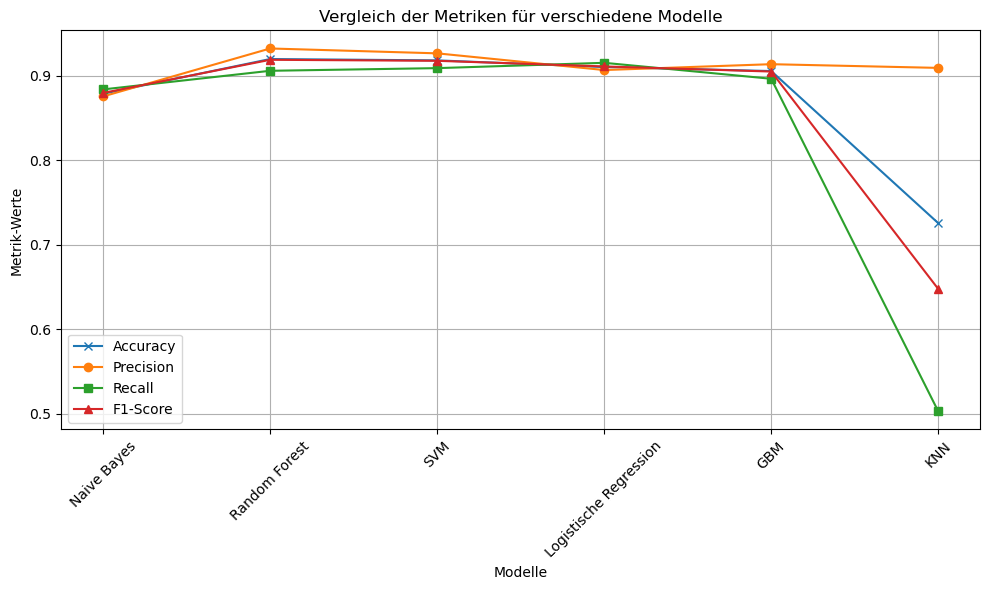

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Modelle und ihre Metriken
models = ["Naive Bayes", "Random Forest", "SVM", "Logistische Regression", "GBM", "KNN"]
accuracy = [accuracy_nb, accuracy_rf, accuracy_svm, accuracy_lr, accuracy_gbm, accuracy_knn]
precision = [precision_nb, precision_rf, precision_svm, precision_lr, precision_gbm, precision_knn]
recall = [recall_nb, recall_rf, recall_svm, recall_lr, recall_gbm, recall_knn]
f1 = [f1_nb, f1_rf, f1_svm, f1_lr, f1_gbm, f1_knn]

# Erstellung einer Tabelle
data = {
    "Modell": models,
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1-Score": f1
}
df = pd.DataFrame(data)

# Anzeigen der Tabelle
print(df)
# Erstellung des Plots
plt.figure(figsize=(10, 6))
plt.plot(models, accuracy, marker='x', label='Accuracy') # als Kreuz
plt.plot(models, precision, marker='o', label='Precision') # als Kreis
plt.plot(models, recall, marker='s', label='Recall') # als Quadrat (square)
plt.plot(models, f1, marker='^', label='F1-Score') # als Dreieck

# Achsenbeschriftungen und Titel
plt.xlabel('Modelle')
plt.ylabel('Metrik-Werte')
plt.title('Vergleich der Metriken für verschiedene Modelle')
plt.xticks(rotation=45)  # Rotiere die x-Achsenbeschriftungen für eine bessere Lesbarkeit
plt.grid(True)
plt.legend()

# Anzeigen des Plots
plt.tight_layout()
plt.show()

### Vergleich der Modelle mittels ROC-Kurven  
<sub> (Receiver Operating Characteristic -> Gibt die Trennschärfe von falsepositiv/truepositiv der Modelle an  
Perfekt wäre 1.00 wenn die Kurve komplett in der Ecke oben links ist)

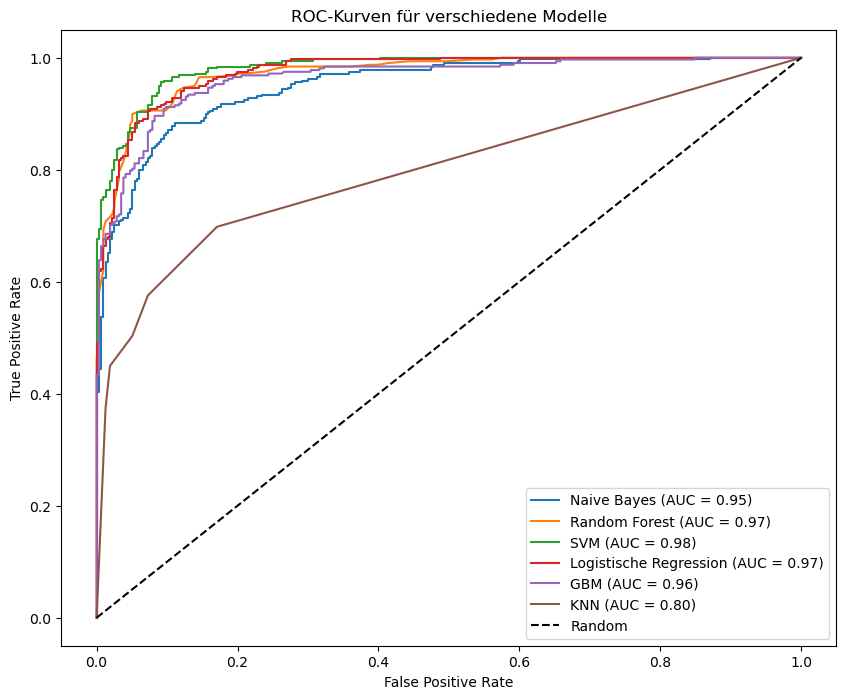

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Berechnen der ROC-Kurven und AUC für jedes Modell
models = [naive_bayes, random_forest, svm_classifier, logistic_regression, gbm_classifier, knn_classifier]
model_names = ["Naive Bayes", "Random Forest", "SVM", "Logistische Regression", "GBM", "KNN"]
    # legt Modelle und Namen fest
plt.figure(figsize=(10, 8))

for model, name in zip(models, model_names):
    if hasattr(model, "decision_function"):
        y_pred_prob = model.decision_function(X_test)
    else:
        y_pred_prob = model.predict_proba(X_test)[:, 1]
    # Prüft ob das jeweilige Modell eine Entscheidungsfunktion besitzt
    # Dementsprechend werden Vorhersagemodelle passend gewählt

    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label="REAL")
    # Festlegung dass "REAL" als positiv gewertet wird
    auc_score = roc_auc_score(y_test, y_pred_prob)
    
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_score:.2f})")
    # Achsenfestlegung

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-Kurven für verschiedene Modelle')
plt.legend(loc="lower right")
plt.show()
